(Started) implementation of a naive triton kernel for hqq-fwd, for axis=1.

**Naming convention:**
- bsx  = block size along axis x
- idx  = index along axis x
- nidx = number of chunks along axis x

eg if len(x) = 10, and we divide x into chunks of size 2 (so 10/2=5 chunks), and are selecting the 4rd chunk (ie 6th and 7th value), then bsx=2, idx=4, nidx=5.

In [36]:
import os
import torch
import numpy as np
from itertools import product

from torch import tensor, cat, int32, float16 as fp16, bfloat16 as bf16, isclose
from tabulate import tabulate

import matplotlib.pyplot as plt

os.environ['TRITON_INTERPRET'] = '1'

import triton
import triton.language as tl
import triton_util as tu

const = tl.constexpr
cdiv, breakpoint_once, print_once = tu.cdiv, tu.breakpoint_once, tu.print_once

torch.set_printoptions(linewidth=200, precision=2, sci_mode=False)
np.set_printoptions(linewidth=200, precision=2) # for triton simulator

In [2]:
dtype = fp16 # can't use bf16 with triton simulator, as numpy doesn't support bf16

In [3]:
b,m,r,n = 2,128,32,64 # batch size, out, lora rank, in
gz, gz2, pz = 64, 128, 10    # group size, group size for quanting zero & scale, pack size (needs to be 10, as we pack 10 x 3bit -> 32bit)

n_p = cdiv(gz,  pz) # number of packs per group (can't name it np due to numpy)
ng  = cdiv(m*n, gz) # number of groups
ng2 = cdiv(ng , gz2)# number of groups for quanting zero/scale

print(f'{n_p = }, {ng = }, {ng2 = }')

n_p = 7, ng = 128, ng2 = 1


In [4]:
assert ng%gz2==0, f'num_groups ({ng}) needs to divide group_size_2 ({gz2}) for quanting of zero & scale to work'
print(f'num_groups ({ng}) divides group_size_2 ({gz2}) ✓')

num_groups (128) divides group_size_2 (128) ✓


In [5]:
def ones(*shape): return torch.ones(*shape, dtype=dtype, device='cuda')

X, A, B = ones(b,n), ones(r,n), ones(m,r)

mag = ones(m) # magnitude
α = 0.9

scale_q, zero_q = ones(gz2, ng2), ones(gz2, ng2)

s_scale, s_zero, z_scale, z_zero = ones(1, ng2), ones(1, ng2), ones(1, ng2), ones(1, ng2)

packed_value = (1 << 29) + (1 << 26)  # first 2 packs set to 1, other 0: 001 001 00000000000000000000000000

bit_repr = [int(o) for o in format(packed_value & 0xFFFFFFFF, '032b')]
assert sum(bit_repr)==2 # only 2 ones...
assert (bit_repr[2], bit_repr[5])==(1,1) # ... at location 2 and 5 

W_qp = torch.full((n_p,ng), packed_value, dtype=int32)

In [6]:
W_qp[:3,:3]

tensor([[603979776, 603979776, 603979776],
        [603979776, 603979776, 603979776],
        [603979776, 603979776, 603979776]], dtype=torch.int32)

In [7]:
W_shape = (m, n)
zero_scale_shape = (1, ng)
print(f'{W_shape = }, {zero_scale_shape = }')

W_shape = (128, 64), zero_scale_shape = (1, 128)


In [8]:
def assert_close(out, expected, do_print=True, atol=1e-5):
    if do_print:
        print(out)
        print(expected)
    assert torch.isclose(out, expected,atol=atol).all(), 'Not close 🤔'
    print('Equal ✅')

### Sub-Kernel 1: Load & Dequant zero / scale

In [9]:
@triton.jit
def dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2: const, ng2: const, shape: const):
    vals_q = tu.load_full_2d(vals_ptr,  sz0=gz2, sz1=ng2, stride0=ng2) # quanted zero/scale values; ~ (gz2, ng2)
    zero   = tu.load_full_1d(zero_ptr,  sz=ng2)                        # zero  of zero/scale;       ~ (ng2)
    scale  = tu.load_full_1d(scale_ptr, sz=ng2)                        # scale of zero/scale;       ~ (ng2)
    vals = (vals_q-zero)*scale
    return vals.reshape(shape)

In [10]:
@triton.jit
def test_dequant_zero_or_scale(out_ptr, vals_ptr, zero_ptr, scale_ptr, gz2: const, ng2: const, shape: const):
    out = dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2, ng2, shape)
    tu.store_full_2d(out, out_ptr, shape[0], shape[1], stride0=shape[1])

zvals = torch.ones((gz2, ng2), device='cuda', dtype=dtype) * 1
zzero = torch.ones((1,   ng2), device='cuda', dtype=dtype) * 2
zscale= torch.ones((1,   ng2), device='cuda', dtype=dtype) * 3
out  = torch.zeros((ng, 1),  device='cuda', dtype=dtype)

test_dequant_zero_or_scale[(1,)](out, zvals, zzero, zscale, gz2, ng2, (ng,1))

In [11]:
assert_close(out, (zvals-zzero)*zscale, do_print=False)

Equal ✅


### Sub-Kernel 2: Load, unpack W_qp

In [13]:
from hqq.core.bitpack import BitPack

In [15]:
DEBUG = False

@triton.jit
def load_W_q(ptr, bsm: const, idm: const, m: const, n: const, gz: const, pz: const):
    '''Load selected rows from W_qp (and all cols)'''

    if DEBUG: print_once('---- Running load_W_q ----')
    if DEBUG: print_once(f'bsm = {bsm}, idm = {idm}, m = {m}, n = {n}, gz = {gz}, pz = {pz}')
    
    offs   = tu.offset_1d(bsm, idm)  # rows of W
    if DEBUG: print_once(f'W rows = {offs}')    
    if DEBUG: print_once(f'grouping multiplier = {n/gz}')    
    
    offs_q = tu.offset_1d(bsm*(n//gz), idm) # rows of W_q ; note: n/gz is integer    
    if DEBUG: print_once(f'W_q rows = {offs_q}')    
    
    npacks = cdiv(m*n//gz, 10)         # number of packed values
    if DEBUG: print_once(f'npacks = {npacks}')    
    
    offs0  = offs_q % npacks           # rows of W_qp
    if DEBUG: print_once(f'W_qp rows = {offs0}')    
    
    shifts = 27 - 3*(offs_q // npacks) # right-shifts needed to unpack correctly, for each row    
    if DEBUG: print_once(f'shifts = {shifts}')    
    
    offs1 = tl.arange(0, gz) # all cols
    if DEBUG: print_once(f'offs1 = {offs1}')    
    
    w_pq_offs = tu.offset_2d(offs0, offs1, stride0=gz)
    if DEBUG: print_once(f'w_pq_offs =\n{w_pq_offs}')    

    w_pq_mask = tu.mask_2d  (offs0, offs1, max0=m*n//gz, max1=gz)
    if DEBUG: print_once(f'w_pq_mask =\n{w_pq_mask}')    

    vals = tl.load(ptr + w_pq_offs, w_pq_mask)
    if DEBUG: print_once(f'vals =\n{vals}')    

    shifted_vals = vals >> shifts[:,None] & 0b111
    if DEBUG: print_once(f'shifted_vals =\n{shifted_vals}')    
    
    return shifted_vals

Let's test it with random 3bit values, for a weight matrix W of size `8x4`

In [16]:
@triton.jit
def test_load_W_q(out_ptr, W_qp_ptr, idm: const, bsm: const, m: const, n: const, gz: const, pz: const):
    W_q = load_W_q(W_qp_ptr, bsm, idm, m, n, gz, pz)
    tu.store_full_2d(W_q, out_ptr, bsm, gz, gz)

In [17]:
m,n=8,4
gz = 4

rand = torch.randint(low=0, high=7, size=(m,n), device='cuda', dtype=dtype)
rand_packed = BitPack.pack_3bit_32(rand.reshape(-1,gz))
rand.shape, rand_packed.shape, m, n, gz, pz

(torch.Size([8, 4]), torch.Size([1, 4]), 8, 4, 4, 10)

In [18]:
bsm=2
for idm in [0,1]:
    print(f'-- idm = {idm}')
    small_bsm = 2
    out = torch.zeros(bsm*(n//gz), gz, device='cuda')
    test_load_W_q[(1,1)](out, rand_packed, idm, bsm, m, n, gz, pz)
    assert_close(out.half(), rand[idm*bsm:(idm+1)*bsm,:].reshape(-1,gz))

-- idm = 0
tensor([[4., 5., 4., 0.],
        [5., 3., 1., 5.]], device='cuda:0', dtype=torch.float16)
tensor([[4., 5., 4., 0.],
        [5., 3., 1., 5.]], device='cuda:0', dtype=torch.float16)
Equal ✅
-- idm = 1
tensor([[6., 0., 0., 4.],
        [1., 1., 3., 5.]], device='cuda:0', dtype=torch.float16)
tensor([[6., 0., 0., 4.],
        [1., 1., 3., 5.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 3: Dequant W

In [19]:
@triton.jit
def dequant_W(W_q, zero, scale, bsm: const, n:const):
    return ((W_q-zero)*scale).reshape(bsm,n)

In [20]:
@triton.jit
def test_dequant_W(out_ptr, vals_ptr, zero_ptr, scale_ptr, bsm: const, n: const, gz: const):
    W_q   = tu.load_full_2d(vals_ptr,  bsm*n//gz, gz, gz)
    zero  = tu.load_full_2d(zero_ptr,  bsm*n//gz, 1,   1)
    scale = tu.load_full_2d(scale_ptr, bsm*n//gz, 1,   1)

    W = dequant_W(W_q, zero, scale, bsm, n)

    tu.store_full_2d(W, out_ptr, bsm, n, n)

In [21]:
bsm = 2
m,n=8,4
gz = 2

vals = torch.ones((bsm*n//gz, gz), device='cuda', dtype=dtype) * 1
zero = torch.ones((bsm*n//gz,  1), device='cuda', dtype=dtype) * 2
scale= torch.ones((bsm*n//gz,  1), device='cuda', dtype=dtype) * 3
out  = torch.zeros((bsm, n),  device='cuda', dtype=dtype)

In [22]:
test_dequant_W[(1,)](out, vals, zero, scale, bsm, n, gz)

In [23]:
assert_close(out, ((vals-zero)*scale).reshape(-1,n))

tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 4: `x@w.t`

In [24]:
# input:
# 1. x[b-chunk,:]
# 2. w[m-chunk,:]
# output x@w.t[b-chunk,m-chunk]

In [25]:
@triton.jit
def batched_matmul(
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, m:const, n:const,          # matrix sizes
    swizzle_group_sz: const 
):
    # determine location of block in grouped ordering - swizzle!     
    nidb, nidm = cdiv(b,bsb), cdiv(m,bsm)
    idb, idm = tl.swizzle2d(idb, idm, nidb, nidm, swizzle_group_sz)
    # 1d offets along b,m,n axes
    offs_b = tu.offset_1d(bsb, idb)
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    # 2d offsets of x, w
    offs_x = x_ptr + tu.offset_2d(offs_b, offs_n, n)
    offs_w = w_ptr + tu.offset_2d(offs_m, offs_n, n)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bsb, bsm), dtype=tl.float32)
    for _ in range(0, n, bsn):
        x = tl.load(offs_x)
        w = tl.load(offs_w)
        acc += tl.dot(x, w.trans(), allow_tf32=False) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offsets, so next iteration loads next chunks
        offs_x += bsn
        offs_w += bsn
    return acc

In [26]:
@triton.jit
def test_batched_mamtul(
    out_ptr,
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, m:const, n:const,          # matrix sizes
    swizzle_group_sz: const 
):
    out = batched_matmul(x_ptr, w_ptr, bsb, bsm, bsn, idb, idm, b, m, n, swizzle_group_sz)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [27]:
b,m,n = 16, 16, 16

bsb,bsm,bsn = 16,16,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)
out = torch.zeros((bsb,bsm),dtype=dtype, device='cuda')

In [28]:
test_batched_mamtul[(cdiv(b,bsb), cdiv(m,bsm))](out, x, w, bsb, bsm, bsn, 0, 0, b,m,n, swizzle_group_sz=2)

In [29]:
assert_close(out, x@w.t(), do_print=False)

Equal ✅


Test it with larger 1-matrices

In [30]:
b,m,n = 128, 128, 128

bsb,bsm,bsn = 32,32,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)

out = torch.zeros((b,m), dtype=dtype, device='cuda')

for idb, idm in product(range(cdiv(b,bsb)), range(cdiv(m,bsm))):
    out_patch = torch.zeros((bsb,bsm),dtype=dtype, device='cuda')
    test_batched_mamtul[(cdiv(b,bsb), cdiv(m,bsm))](out_patch, x, w, bsb, bsm, bsn, idb, idm, b,m,n, swizzle_group_sz=2)

    min_b =     idb*bsb
    max_b = (idb+1)*bsb
    min_m =     idm*bsm
    max_m = (idm+1)*bsm
    
    max_b = min(max_b,b)
    max_m = min(max_m,m)

    out[min_b:max_b, min_m:max_m] = out_patch[:max_b-min_b, :max_m-min_m]

In [31]:
assert_close(out, x@w.t(), do_print=False)

Equal ✅


Test it with larger random matrices

In [ ]:
Note: The 

In [48]:
# from triton.language.standard.py
def swizzle2d(i, j, size_i, size_j, size_g):
    ij = i * size_j + j
    size_gj = size_g * size_j
    group_id = ij // size_gj
    off_i = group_id * size_g
    size_g = min(size_i - off_i, size_g)
    new_i = off_i + (ij % size_g)
    new_j = (ij % size_gj) // size_g
    return new_i, new_j

In [51]:
b,m,n = 32, 32, 32

bsb,bsm,bsn = 16,16,16 # tl.dot requires all axes to be >= 16

x = torch.rand((b,n), dtype=dtype, device='cuda')
w = torch.rand((m,n), dtype=dtype, device='cuda')

out = torch.zeros((b,m), dtype=dtype, device='cuda')

In [57]:
nidb, nidm = cdiv(b,bsb), cdiv(m,bsm)
for idb, idm in product(range(nidb), range(nidm)):
    out_patch = torch.zeros((bsb,bsm),dtype=dtype, device='cuda')
    test_batched_mamtul[(cdiv(b,bsb), cdiv(m,bsm))](out_patch, x, w, bsb, bsm, bsn, idb, idm, b,m,n, swizzle_group_sz=2)

    idb, idm = swizzle2d(idb, idm, nidb, nidm, size_g=2)
    
    min_b =     idb*bsb
    max_b = (idb+1)*bsb
    min_m =     idm*bsm
    max_m = (idm+1)*bsm
    
    max_b = min(max_b,b)
    max_m = min(max_m,m)

    out[min_b:max_b, min_m:max_m] = out_patch[:max_b-min_b, :max_m-min_m]

assert_close(out, x@w.t(), do_print=False)

Equal ✅


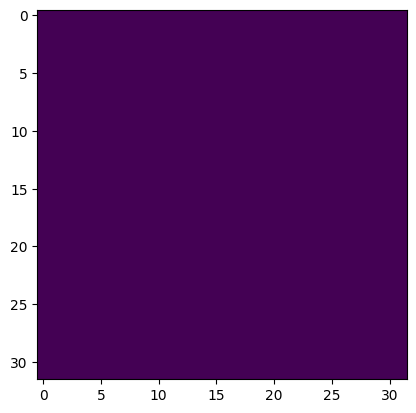

In [56]:
err = (out-x@w.t()).abs().cpu()
plt.imshow(err)
plt.show()

### Sub-Kernel 5: `x@a.t@b.t`

In [ ]:
# todo

### Sub-Kernel 6: colnorm

In [ ]:
# todo

### Sub-Kernel 7: `* α, β, mag, 1/colnorm`

In [ ]:
# todo

### Full Kernel

In [ ]:
def fwd_op(fwd_k, bsb, bsm, bsr, bsn):
    # for simplicity, following vars are used from closure & will instead be passed in actual op:
    #   X, A, B, W_qp, scale_q, zero_q,
    #   mag, s_scale, s_zero, z_scale, z_zero
    #   α
    #   W_shape, zero_scale_shape 
    # these vars will be computed from in actual op, but are also used from closure for simplicity
    #   b,m,r,n

    Y = torch.zeros((b,m),dtype=bf16, device='cuda')
    assert_tensors_gpu_ready(Y, X, A, B, mag, scale_q, zero_q, s_scale, s_zero, z_scale, z_zero, W_qp)

    grid = (cdiv(b, bsb), cdiv(m, bsm))
    print(f'Launching grid of size {grid}')
    
    fwd_k[grid](
        # input matrices
        X, A, B, W_qp, scale_q, zero_q, 
        # input vectors
        mag, s_scale, s_zero, z_scale, z_zero,
        # input scalars
        α,
        # output matrix
        Y,
        # dimensions
        b,m,r,n,
        # grouping / packing configs
        gz, gz2, pz,
        # shapes to undo grouping
        W_shape, zero_scale_shape,
        # block sizes
        bsb, bsm, bsr, bsn
        # strides
        # todo
    )
    return Y

In [ ]:
# # total todo:
# dequant zero & scale
# unpack w
# dequant w    
# x@w.t
# x@a.t@b.t
# build colnorm
# times alpha, mag, 1/colnorm

@triton.jit
def forward_k(
    # input matrices
    X_ptr, A_ptr, B_ptr, W_qp_ptr, scale_q_ptr, zero_q_ptr,
    # input vectors
    mag_ptr, s_scale_ptr, s_zero_ptr, z_scale_ptr, z_zero_ptr,
    # input scalars
    α,
    # output matrix
    Y_ptr,
    # dimensions
    b: tl.constexpr, m: tl.constexpr, r: tl.constexpr, n: tl.constexpr,
    # grouping / packing configs
    gz: tl.constexpr, gz2: tl.constexpr, pz: tl.constexpr,
    # shapes to undo grouping
    W_shape: tl.constexpr, zero_scale_shape: tl.constexpr, 
    # block sizes
    bsb: tl.constexpr, bsm: tl.constexpr, bsr: tl.constexpr, bsn: tl.constexpr,
    # strides
    # todo
):
    tl.static_assert(m%gz and n%gz, f'group_size ({gz}) must divide m ({m}) and n ({n})')
    
    pid0, pid1 = tl.program_id(0), tl.program_id(1) # blocks correspond to chunking of b and m axes

    n_p: tl.constexpr  = cdiv(gz,  pz)  # number of packs per group (can't name it np due to numpy)
    ng:  tl.constexpr  = cdiv(m*n, gz)  # number of groups
    ng2: tl.constexpr  = cdiv(ng,  gz2) # number of groups for quanting zero/scale
    
    # # dequant zero & scale
    zero  = dequant_zero_or_scale(zero_q_ptr,  z_zero_ptr, z_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    scale = dequant_zero_or_scale(scale_q_ptr, s_zero_ptr, s_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    # # unpack w
    qp_row_lo, qp_row_hi = rows_in_W_pq(bsm, pid1, m, n, gz, pz)        # determine which rows of W_qp are relevant
    w_qp = load_W_qp(W_qp_ptr, qp_row_lo, qp_row_hi, row_max=n_p, ng=ng) # load those rows (and all cols)

    breakpoint_once()

    
    # dequant w
    
    # x@w.t
    # x@a.t@b.t
    # build colnorm
    # times alpha, mag, 1/colnorm
    
    pass

In [ ]:
block_sizes = dict(bsb=2, bsm=2, bsr=2, bsn=2)
fwd_op(forward_k, **block_sizes)

In [ ]:
raise ValueError()

In [ ]:
def qp_rows(lo, hi, pz, gz, m, n):
    assert m%gz==n%gz==0, 'gz must divide m and n'
    qlo, qhi = lo*n//gz, hi*n//gz
    npacks = cdiv((m*n//gz), 10)
    plo, phi = qlo%npacks, qhi%npacks
    print(f'groups = {int(m*n/gz)}, packs = {npacks}')
    print(f'rows: {lo},{hi}\nquanted rows: {qlo}, {qhi}\npacked rows: {plo}, {phi}')

In [ ]:
qp_rows(10, 14, pz, gz, m, n)

In [ ]:
m,n,gz

In [ ]:
cdiv??